In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from datetime import datetime
import seaborn as sns
%matplotlib inline

In [2]:
weather=pd.read_csv('austin_weather.csv').drop(['DewPointHighF','DewPointLowF','HumidityHighPercent','HumidityLowPercent',
                                               'SeaLevelPressureHighInches','SeaLevelPressureLowInches','VisibilityHighMiles',
                                               'VisibilityLowMiles','WindHighMPH','WindGustMPH','HumidityAvgPercent'],1)
trips=pd.read_csv('austin_bikeshare_trips.csv')
station=pd.read_csv('austin_bikeshare_stations_w_zipcode.csv')
weather.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointAvgF,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,49,29.68,7,4,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,36,30.13,10,6,0,
2,2013-12-23,58,45,32,27,30.49,10,3,0,
3,2013-12-24,61,46,31,28,30.45,10,4,0,
4,2013-12-25,58,50,41,40,30.33,10,2,T,


In [3]:
weather.Events.unique()
weather['Rain']=np.where(weather.Events.str.contains('Rain'), 1, 0)
weather.Date=pd.to_datetime(weather.Date)
weather=weather.set_index('Date').drop('Events',1)

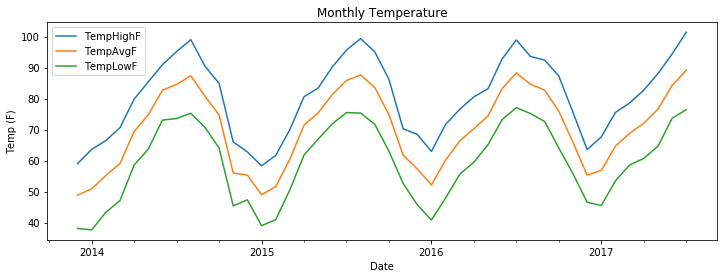

In [4]:
weather[['TempHighF', 'TempAvgF', 'TempLowF']].resample('M').mean().plot(title='Monthly Temperature', figsize=(12,4))
plt.ylabel('Temp (F)')
plt.show()

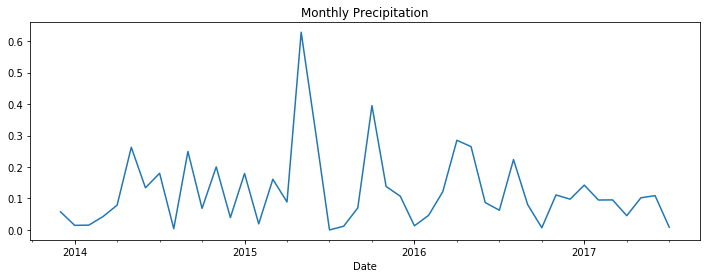

In [5]:
weather['PrecipitationSumInches']=pd.to_numeric(weather['PrecipitationSumInches'],errors='coerce')
weather['PrecipitationSumInches'].resample('M').mean().plot(title='Monthly Precipitation', figsize=(12, 4))
plt.show()

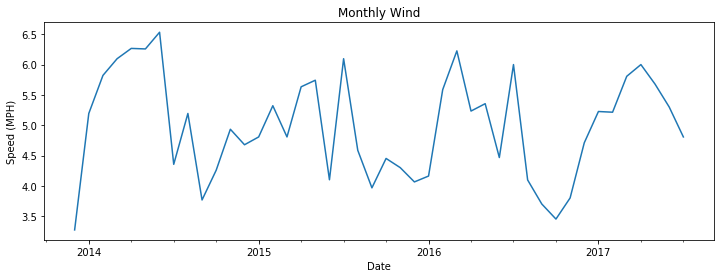

In [6]:
weather['WindAvgMPH']=pd.to_numeric(weather['WindAvgMPH'],errors='coerce')
weather['WindAvgMPH'].resample('M').mean().plot(title='Monthly Wind', figsize=(12,4))
plt.ylabel('Speed (MPH)')
plt.show()

In [7]:
ind = pd.DatetimeIndex(trips.start_time)
trips['Date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
by_date = trips.pivot_table('trip_id', aggfunc='count',index='Date',columns='subscriber_type', )
by_date = trips.groupby(['Date', 'subscriber_type'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('subscriber_type')
trips_2=trips[trips.year.isin([2014,2015,2016])]
trip_weather=trips_2.merge(weather,left_on='Date',right_on='Date',
                         suffixes=['_trips','_weather']).drop(['SeaLevelPressureAvgInches'],1)
trip_weather=trip_weather.drop(['DewPointAvgF','VisibilityAvgMiles','end_station_id','end_station_name','bikeid',
                                'TempHighF','TempLowF'],1)

In [8]:
trip_weather.head()

,checkout_time,duration_minutes,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year,Date,hour,TempAvgF,WindAvgMPH,PrecipitationSumInches,Rain
0,19:12:00,41,3.0,2536.0,Waller & 6th St.,2015/3/19 19:12,Walk Up,9900082882,2015.0,2015-03-19,19,73,5.0,0.0,0
1,16:12:00,22,3.0,2499.0,City Hall / Lavaca & 2nd,2015/3/19 16:12,Walk Up,9900082182,2015.0,2015-03-19,16,73,5.0,0.0,0
2,20:12:00,29,3.0,2563.0,Davis at Rainey Street,2015/3/19 20:12,Walk Up,9900083166,2015.0,2015-03-19,20,73,5.0,0.0,0
3,15:12:00,31,3.0,2711.0,Barton Springs @ Kinney Ave,2015/3/19 15:12,Walk Up,9900081791,2015.0,2015-03-19,15,73,5.0,0.0,0
4,17:12:00,247,3.0,2575.0,Riverside @ S. Lamar,2015/3/19 17:12,Walk Up,9900082453,2015.0,2015-03-19,17,73,5.0,0.0,0


## correlation matrix of weather

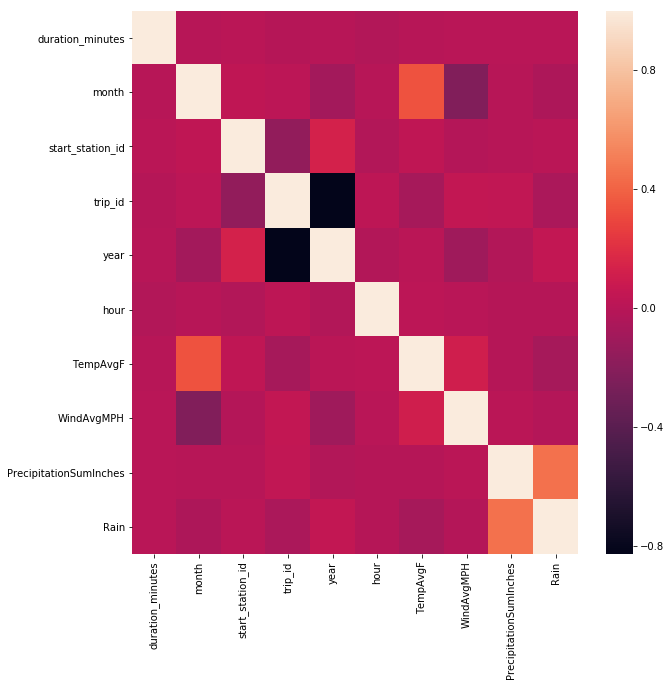

In [9]:
correlation=trip_weather.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation, ax=ax)

## weather effects to station

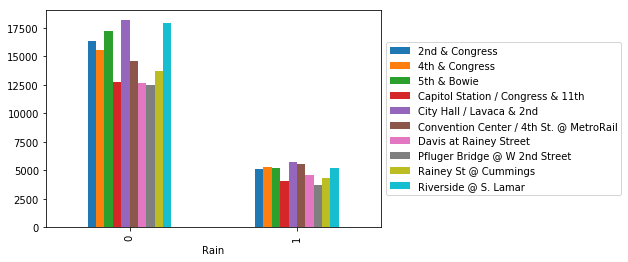

In [10]:
rain_station=trip_weather.groupby('Rain')['start_station_name'].apply(lambda x:x.value_counts().head(10))
temp_station=trip_weather.groupby('TempAvgF')['start_station_name'].apply(lambda x:x.value_counts().head(10))
rain_station.unstack().plot(kind='bar')
plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5))

## Rain effects on rider counts based on seasons, stations and membership

In [11]:
trip_weather.loc[trip_weather['month'].isin([3,4,5]), 'season'] = 'Spring'
trip_weather.loc[trip_weather['month'].isin([6,7,8]), 'season'] = 'Summer'
trip_weather.loc[trip_weather['month'].isin([9,10,11]), 'season'] = 'Fall'
trip_weather.loc[trip_weather['month'].isin([12,1,2]), 'season'] = 'Winter'

In [12]:
rain_season=trip_weather.groupby(['season','Rain'])['trip_id'].count().unstack()
rain_season['percentage drop']=(rain_season[0]-rain_season[1])/rain_season[0]
rain_season

Rain,0,1,percentage drop
season,,,
Fall,115087,34766,0.697915
Spring,106176,60758,0.427761
Summer,109199,19854,0.818185
Winter,66020,13044,0.802424


In [13]:
rainy=trip_weather.groupby('Rain')['trip_id'].count()
rainy['percentage drop']=(rainy[0]-rainy[1])/float(rainy[0])
rainy
# about 70% decrease of people who ride bikes in rainy days

Rain
0                  396482.000000
1                  128422.000000
percentage drop         0.676096
Name: trip_id, dtype: float64

In [14]:
rain_station=trip_weather.groupby(['start_station_name','Rain'])['trip_id'].count().unstack()
rain_station['percentage drop']=(rain_station[0]-rain_station[1])/rain_station[0]
rain_station[rain_station[0]>=1000].sort_values(0,ascending=False).head()
# not obvious difference pattern of number of bike riders in rainy days between stations

Rain,0,1,percentage drop
start_station_name,,,
City Hall / Lavaca & 2nd,18166.0,5730.0,0.684576
Riverside @ S. Lamar,17973.0,5216.0,0.709787
5th & Bowie,17219.0,5180.0,0.699170
2nd & Congress,16374.0,5092.0,0.689019
4th & Congress,15537.0,5294.0,0.659265


In [15]:
trip_weather_member=trip_weather[trip_weather['year'].isin([2015,2016,2017])]
rain_membership=trip_weather_member.groupby(['subscriber_type','Rain'])['trip_id'].count().unstack()
rain_membership
rain_membership['percentage drop']=(rain_membership[0]-rain_membership[1])/rain_membership[0]
rain_membership.sort_values('percentage drop',ascending=False)

Rain,0,1,percentage drop
subscriber_type,,,
Explorer ($8 plus tax),179.0,7.0,0.960894
Local365 ($80 plus tax),3749.0,256.0,0.931715
Weekender ($15 plus tax),522.0,44.0,0.915709
Local30 ($11 plus tax),760.0,80.0,0.894737
Annual (Boulder B-cycle),36.0,6.0,0.833333
Republic Rider (Annual),17.0,3.0,0.823529
Annual (Nashville B-cycle),14.0,3.0,0.785714
Annual,507.0,109.0,0.785010
Annual (Cincy Red Bike),16.0,4.0,0.750000


## Temperature effects on rider counts based on seasons, stations and membership

In [16]:
trip_weather['Temp']='Medium Temp'
trip_weather.loc[trip_weather['TempAvgF']>=80,'Temp']='High Temp'
trip_weather.loc[trip_weather['TempAvgF']<=59,'Temp']='Low Temp'

In [17]:
temperature=trip_weather.groupby('Temp')['trip_id'].count()
temperature['percent drop in hot days']=(temperature['Medium Temp']-temperature['High Temp'])/float(temperature['Medium Temp'])
temperature['percent drop in cold days']=(temperature['Medium Temp']-temperature['Low Temp'])/float(temperature['Medium Temp'])
temperature
# about 35% drop in hot days and 70% drop in cold days since Austin people are more used to the high tempearture hhhhhh

Temp
High Temp                    174448.000000
Low Temp                      75851.000000
Medium Temp                  274605.000000
percent drop in hot days          0.364731
percent drop in cold days         0.723781
Name: trip_id, dtype: float64

In [18]:
temp_station=trip_weather.groupby(['start_station_name','Temp'])['trip_id'].count().unstack()
temp_station['percent drop in hot days']=(temp_station['Medium Temp']-temp_station['High Temp'])/temp_station['Medium Temp']
temp_station['percent drop in cold days']=(temp_station['Medium Temp']-temp_station['Low Temp'])/temp_station['Medium Temp']
temp_station[temp_station['Medium Temp']>=500].sort_values('Medium Temp',ascending=False).head(20)
# no obvious difference pattern of number of bike riders in hot or cold days for stations

Temp,High Temp,Low Temp,Medium Temp,percent drop in hot days,percent drop in cold days
start_station_name,,,,,
City Hall / Lavaca & 2nd,7792.0,3681.0,12423.0,0.372776,0.703695
Riverside @ S. Lamar,8486.0,3205.0,11498.0,0.261959,0.721256
2nd & Congress,7388.0,2741.0,11337.0,0.348328,0.758225
5th & Bowie,7636.0,3687.0,11076.0,0.310581,0.667118
Convention Center / 4th St. @ MetroRail,5940.0,3237.0,10978.0,0.458918,0.705138
4th & Congress,6977.0,3249.0,10605.0,0.342103,0.693635
Davis at Rainey Street,5147.0,2204.0,9843.0,0.477090,0.776085
Rainey St @ Cummings,6812.0,2466.0,8801.0,0.225997,0.719805
Capitol Station / Congress & 11th,5718.0,2809.0,8278.0,0.309253,0.660667


## Temperature influence on membership

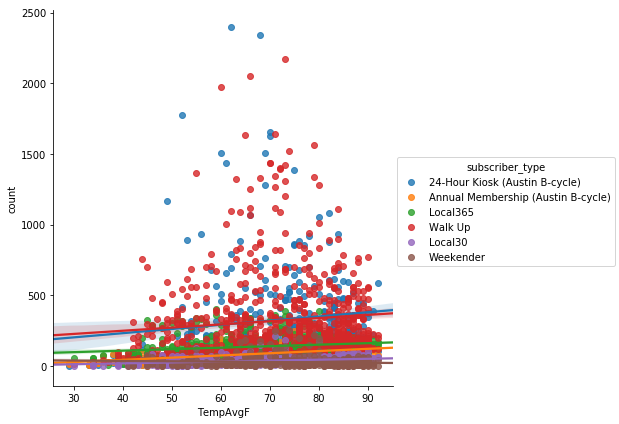

In [19]:
a=trip_weather['subscriber_type'].value_counts().head(6)
trip_weather=trip_weather[trip_weather['subscriber_type'].map(lambda x: x in a)]
trip_weather2=trip_weather.groupby(['Date', 'subscriber_type'])['trip_id'].count()
trip_weather2.name = 'count'
trip_weather2=trip_weather2.reset_index('subscriber_type').join(weather)
g = sns.FacetGrid(trip_weather2, hue='subscriber_type', size=6)
g.map(sns.regplot,"TempAvgF","count")
g.add_legend()

## Precipitation effects on membership

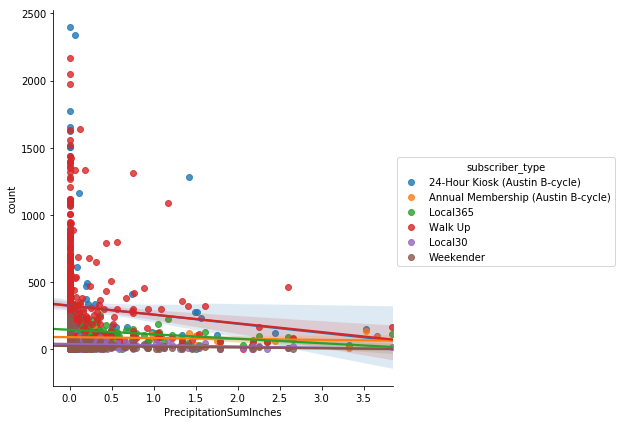

In [20]:
g = sns.FacetGrid(trip_weather2, hue='subscriber_type', size=6)
g.map(sns.regplot,"PrecipitationSumInches","count")
g.add_legend()